# Torch-dreams

This library was heavily inspired from: [Feature Visualization: How neural networks build up their understanding of images](https://distill.pub/2017/feature-visualization/)

<img src = "https://github.com/Mayukhdeb/torch-dreams/blob/master/images/banner_segmentation_model.png?raw=true">


## Quick start 

In [ ]:
# !pip install torch-dreams  --upgrade
!pip install git+https://github.com/Mayukhdeb/torch-dreams  ## for testing only 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from torch_dreams.dreamer import dreamer
import torchvision.models as models
plt.rcParams['figure.figsize'] = 5,5

## Minimal example

In [154]:
model = models.inception_v3(pretrained=True)
dreamy_boi = dreamer(model, device = 'cuda', quiet =  False)

In [155]:
image_param = dreamy_boi.render(
    layers = [model.Mixed_5b],
)

100%|██████████| 120/120 [00:03<00:00, 35.06it/s]


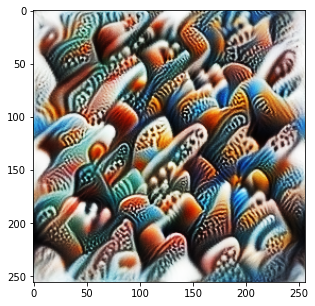

In [156]:
plt.imshow(image_param.rgb)
plt.show()

## Not so minimal looking example, but does the same thing as above



In [157]:
image_param = dreamy_boi.render(
    layers = [model.Mixed_5b],
    width = 512,
    height = 256,
    iters = 150,
    lr = 9e-3,
    rotate_degrees = 15,
    scale_max = 1.2,
    scale_min =  0.5,
    translate_x = 0.2,
    translate_y = 0.2,
    custom_func = None,
    weight_decay = 1e-2,
    grad_clip = 1,
)

100%|██████████| 150/150 [00:03<00:00, 38.19it/s]


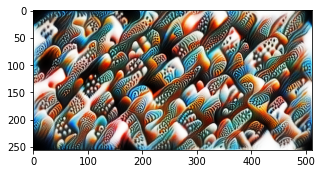

In [158]:
plt.imshow(image_param.rgb)
plt.show()

## Visualizing individual channels


We basically optimize the input image to maximize activations of a certain channel of a layer in the neural network.

The next step now would be to define a `custom_func` that would enable use to selectively optimize a single channel. We could've made a simpler function, but this would be useful when we'll be running the optimizations on a lot of channels

In [10]:
"""
feel free to use more layers for experiments 
"""
layers_to_use = [model.Mixed_6b.branch1x1.conv]

def make_custom_func(layer_number = 0, channel_number= 0): 
    def custom_func(layer_outputs):
        loss = layer_outputs[layer_number][channel_number].mean()
        return -loss
    return custom_func

Now in order to optimize the **7th channel** of the **first layer** mentioned in `layers_to_use` we define the custom loss as:



In [11]:
my_custom_func = make_custom_func(layer_number= 0, channel_number = 119)

100%|██████████| 200/200 [00:06<00:00, 32.55it/s]


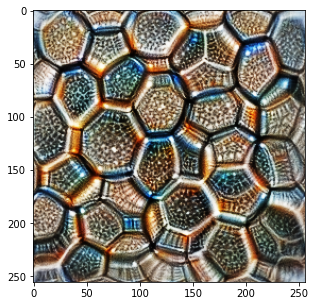

In [13]:
image_param = dreamy_boi.render(
    layers = layers_to_use,
    custom_func = my_custom_func,
    iters = 200
)
plt.imshow(image_param.rgb)
plt.show()

## Usimg multiple models 

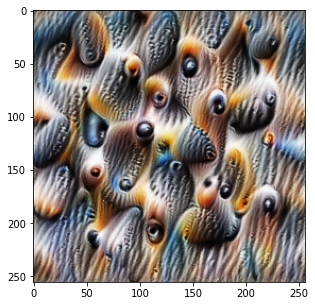

In [15]:
import matplotlib.pyplot as plt
import torchvision.models as models

from torch_dreams.dreamer import dreamer
from torch_dreams.model_bunch import ModelBunch

bunch = ModelBunch(
    model_dict = {
        'inception': models.inception_v3(pretrained=True).eval(),
        'resnet':    models.resnet18(pretrained= True).eval()
    }
)

layers_to_use = [
            bunch.model_dict['inception'].Mixed_6a,
            bunch.model_dict['resnet'].layer2[0].conv1
        ]

dreamy_boi = dreamer(model = bunch, quiet= True, device= 'cuda')

def custom_func(layer_outputs):
    loss =   layer_outputs[0].mean()*2.0 + layer_outputs[1][89].mean() 
    return -loss

image_param = dreamy_boi.render(
    layers = layers_to_use,
    custom_func= custom_func,
    iters= 100
)

plt.imshow(image_param.rgb)
plt.show()

## Optimizing output channels of a segmentation model

In [ ]:
segmentation_model = models.segmentation.deeplabv3_resnet50(pretrained=True).eval()
dreamy_boi = dreamer(segmentation_model, quiet = True, device = 'cuda')
layers_to_use = [
    segmentation_model.aux_classifier[-1]
]

classes = ['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [19]:
all_outs = []
for i in range(21):
    my_func = make_custom_func(layer_number=0, channel_number= i)
    image_param = dreamy_boi.render(
        width = 256,
        height = 256,
        iters = 150,
        layers = layers_to_use,
        custom_func= my_func,
        lr = 8e-3,
        rotate_degrees = 25,
        scale_max= 1.2,
        scale_min= 0.2
    )
    all_outs.append(image_param.rgb)

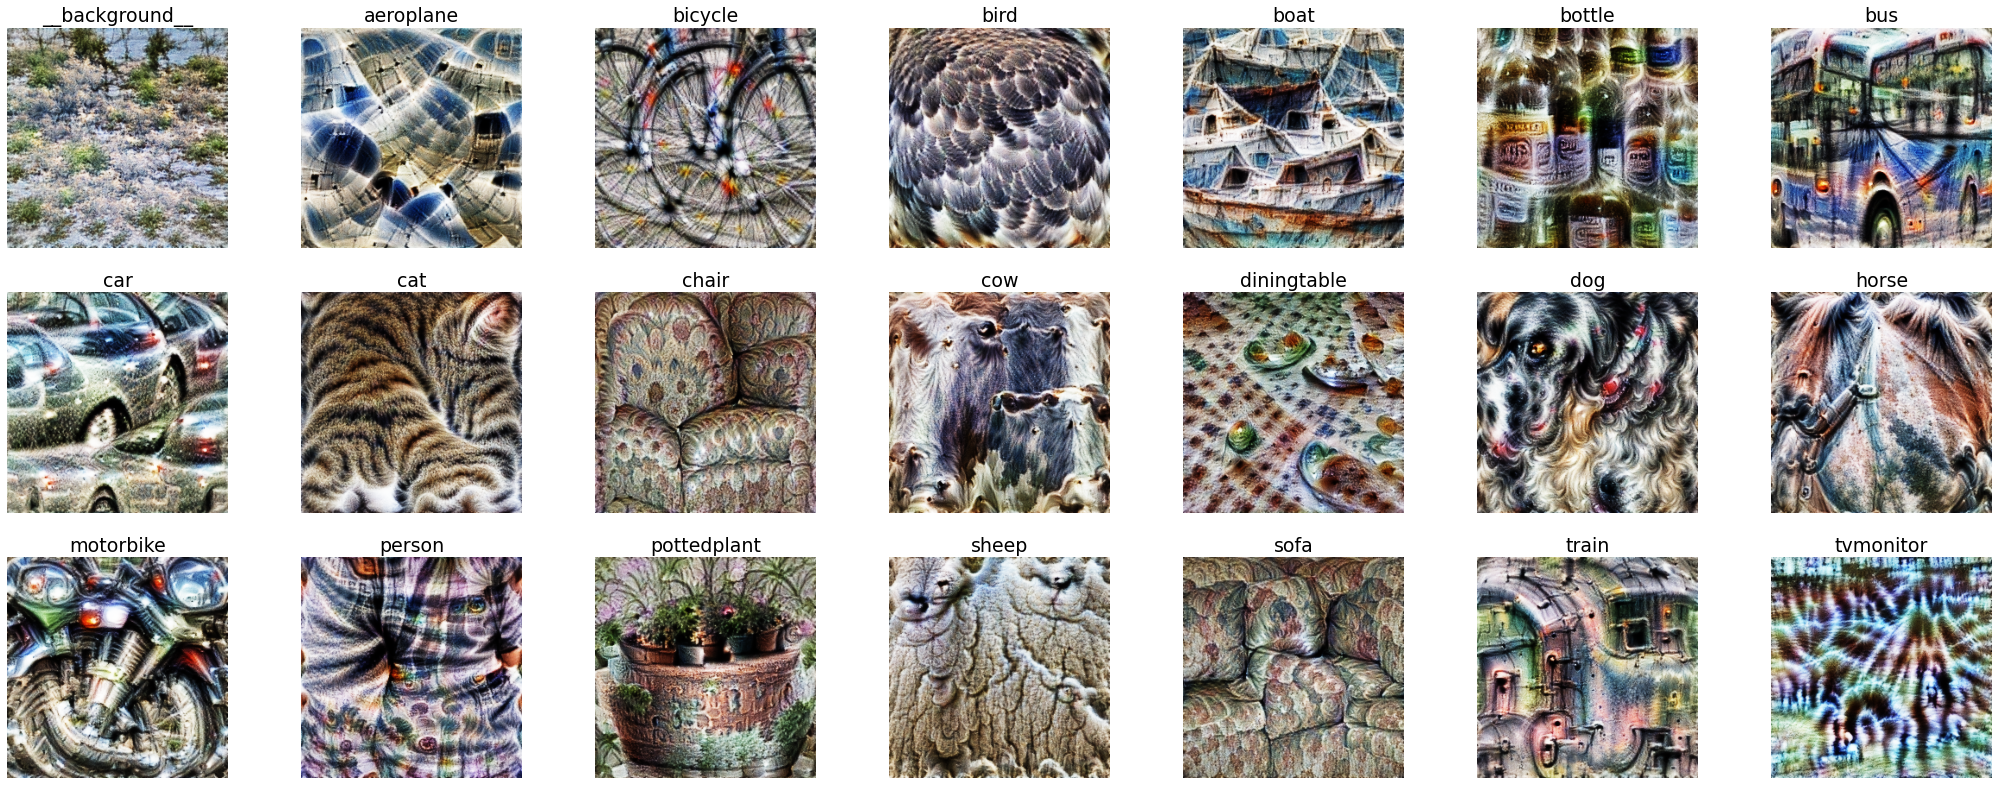

In [20]:
fig, ax = plt.subplots(nrows= 3, ncols= len(classes)//3, figsize=(18*2, 6*2.3))

for i in range(len(all_outs)):
    ax.flat[i].imshow(all_outs[i])
    ax.flat[i].set_title(classes[i], fontsize = 19)
    ax.flat[i].axis("off")

In [21]:
cherry_picked_indices = [6,15, 16, 14, 4, 13]
all_outs_cherry = []
dreamy_boi.quiet = True

for i in cherry_picked_indices:
    my_func = make_custom_func(layer_number=0, channel_number= i)
    image_param = dreamy_boi.render(
        width = 512,
        height = 256,
        iters = 250,
        layers = layers_to_use,
        custom_func= my_func,
        lr = 8e-3,
        rotate_degrees = 15,
        scale_max= 1.2,
        scale_min= 0.1,
        weight_decay = 1e-3
    )

    # plt.imshow(image_param.rgb)
    # plt.show()
    all_outs_cherry.append(image_param.rgb)

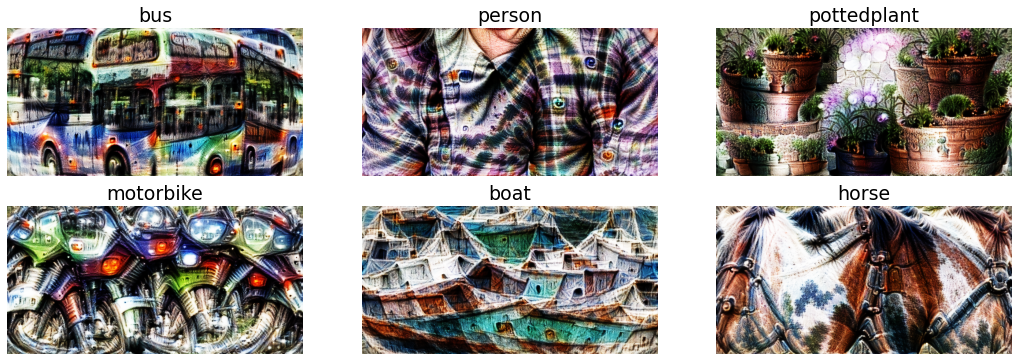

In [ ]:
fig, ax = plt.subplots(nrows= 2, ncols= 3, figsize=(18, 6))

c = 0
for i in cherry_picked_indices:
    ax.flat[c].imshow(all_outs_cherry[c])
    ax.flat[c].set_title(classes[i], fontsize = 19)
    ax.flat[c].axis("off")
    c +=1 

In [ ]:
import cv2
!mkdir images
c = 0
for i in cherry_picked_indices:
    filename = 'images/' + classes[i]+ '.jpg'
    img = cv2.cvtColor((all_outs_cherry[c]*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
    cv2.imwrite(filename, img)
    print(filename)
    c+=1 

## Let's combine features of a segmentation model and inception_v3 




In [123]:
bunch = ModelBunch(
    model_dict = {
        'deeplab': models.segmentation.deeplabv3_resnet50(pretrained=True).eval(),
        'inception':  models.inception_v3(pretrained= True).eval(),
    }
)

layers_to_use = [
            bunch.model_dict['deeplab'].aux_classifier[-1],
            bunch.model_dict['inception'].Mixed_5b,
        ]

dreamy_boi = dreamer(model = bunch, quiet= False, device= 'cuda')


In [124]:
import torch

In [146]:
def custom_func(layer_outputs):
    loss =  layer_outputs[1].mean()*10  + layer_outputs[0][16].mean() *0.2
    return -loss


In [147]:
image_param = dreamy_boi.render(
    width = 512,
    height = 256,
    iters = 150,
    layers = layers_to_use,
    custom_func= custom_func,
    lr= 8e-3,
    rotate_degrees = 15,
    scale_max= 1.2,
    scale_min= 0.5,
    weight_decay = 1e-3
)

100%|██████████| 150/150 [00:13<00:00, 10.96it/s]


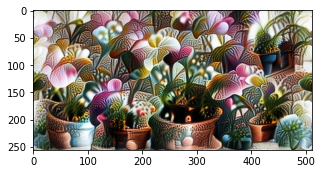

In [148]:
plt.imshow(image_param.rgb)
plt.show()

In [153]:
cv2.imwrite('flower_plus_layer_texture.jpg',cv2.cvtColor((image_param.rgb*255).astype(np.uint8), cv2.COLOR_BGR2RGB))

True